In [1]:
import os
import os.path as op
import boto3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
from skimage.filters import try_all_threshold
from diff_classifier import aws
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import resize
import numpy.ma as ma
from skimage import morphology
from scipy.ndimage.morphology import distance_transform_edt as Euclidean

In [2]:
from diff_classifier import PNNs

In [3]:
s3_bucket = 'mckenna.data'
s3_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
s3_img_filename = '{}_z_stack_MaxIP.tif'.format(prefix)
s3_feat_filename = "features_{}.csv".format(prefix)
aws.download_s3('{}/{}'.format(s3_folder,s3_feat_filename), s3_feat_filename, bucket_name=s3_bucket)
feat_name = s3_feat_filename
feat_df = pd.read_csv(feat_name)
aws.download_s3('{}/{}'.format(s3_folder,s3_img_filename), s3_img_filename, bucket_name = s3_bucket)
img = skimage.io.imread(s3_img_filename)

In [4]:
feat_df

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,straightness,MSD_ratio,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2
0,0,0.0,4.066274e-01,1.234418,1.729094,0.934477,0.130155,0.351253,2.015855,0.503933,...,0.181068,0.197753,37.0,509.015730,1142.000000,19.158695,200.923109,1.491304,0.408862,NaN
1,1,1.0,7.617790e-02,22.602545,2.844596,0.935092,0.129522,0.352340,3.622573,0.723953,...,0.003115,10.324101,121.0,506.762867,1151.349323,19.015180,233.703120,1.981142,1.475014,0.141288
2,2,2.0,1.473815e-08,22.318937,2.738254,0.845722,0.204613,0.245884,1.783135,0.439190,...,0.005438,0.324045,651.0,992.308138,1406.011083,21.289274,259.155908,2.653319,1.542021,0.324345
3,3,3.0,1.199997e+00,0.315534,3.486660,0.684978,0.307101,0.151410,1.476176,0.322574,...,0.029159,0.009585,552.0,534.741736,1124.659826,28.118277,246.298042,1.584998,3.505944,0.972378
4,4,4.0,6.867712e-01,4.453814,2.048315,0.455501,0.440563,0.078401,1.097825,0.089108,...,0.107175,0.014230,95.0,524.004213,1153.821478,19.130313,215.748511,1.905066,1.853615,NaN
5,5,5.0,3.417332e-02,0.008623,2.716543,0.412137,0.466950,0.068300,1.372950,0.271641,...,0.000699,1.017559,651.0,1527.849205,1289.100075,62.646489,333.839246,0.801680,0.000802,0.000095
6,6,6.0,1.036454e+00,1.144086,1.817863,0.899142,0.163010,0.299709,1.504469,0.335314,...,0.126723,0.033046,44.0,1273.056117,1260.794551,15.521922,184.073643,1.497412,1.090887,NaN
7,7,7.0,1.737973e-01,0.173863,3.209750,0.865935,0.189659,0.263946,2.116179,0.527450,...,0.001234,0.887160,651.0,1531.519726,1266.492676,18.100289,275.027304,2.622062,0.028056,0.003549
8,8,8.0,1.235342e-07,23.080683,2.520168,0.780448,0.248782,0.199595,1.946014,0.486129,...,0.004089,0.841225,496.0,1274.293518,1264.200154,24.891050,217.978307,1.351537,1.749976,0.237328
9,9,9.0,2.125024e-01,7.290224,1.958600,0.057650,0.782795,0.007449,1.015960,0.015709,...,0.074728,0.163186,51.0,1280.257552,1263.243048,28.388398,226.960936,1.236547,1.385392,NaN


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


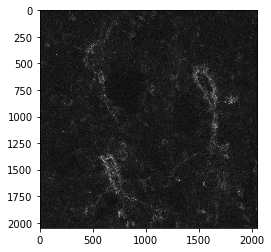

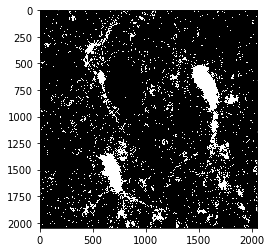

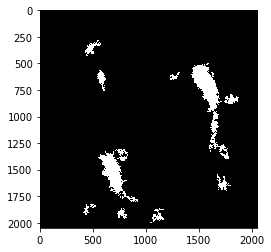

/home/ubuntu/source/diff-classifier/diff_classifier/PNNs.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raw_df['Euc'][i] = euc_img[int(round(raw_df['X'][i])),int(round(raw_df['Y'][i]))]
/home/ubuntu/source/diff-classifier/diff_classifier/PNNs.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raw_df['Bin'][i] = 5
/home/ubuntu/source/diff-classifier/diff_classifier/PNNs.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raw_df['Bin'][i] = 6
/home/ubuntu/source/diff-classifier/

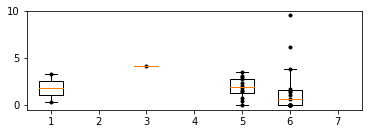

In [5]:
Deff1_binning, Deff1_plot_data, Deff1_x, Deff_1_y = PNNs.PNN_binning(img, feat_df, min_obj_size=3000, feat = 'Deff1', box_plot=True)


In [6]:
Deff1_binning

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2,Euc,Bin
0,0,0.0,4.066274e-01,1.234418,1.729094,0.934477,0.130155,0.351253,2.015855,0.503933,...,37.0,509.015730,1142.000000,19.158695,200.923109,1.491304,0.408862,NaN,125.992063,5.0
1,1,1.0,7.617790e-02,22.602545,2.844596,0.935092,0.129522,0.352340,3.622573,0.723953,...,121.0,506.762867,1151.349323,19.015180,233.703120,1.981142,1.475014,0.141288,120.917327,5.0
2,2,2.0,1.473815e-08,22.318937,2.738254,0.845722,0.204613,0.245884,1.783135,0.439190,...,651.0,992.308138,1406.011083,21.289274,259.155908,2.653319,1.542021,0.324345,167.370846,6.0
3,3,3.0,1.199997e+00,0.315534,3.486660,0.684978,0.307101,0.151410,1.476176,0.322574,...,552.0,534.741736,1124.659826,28.118277,246.298042,1.584998,3.505944,0.972378,124.823876,5.0
4,4,4.0,6.867712e-01,4.453814,2.048315,0.455501,0.440563,0.078401,1.097825,0.089108,...,95.0,524.004213,1153.821478,19.130313,215.748511,1.905066,1.853615,NaN,107.056060,5.0
5,5,5.0,3.417332e-02,0.008623,2.716543,0.412137,0.466950,0.068300,1.372950,0.271641,...,651.0,1527.849205,1289.100075,62.646489,333.839246,0.801680,0.000802,0.000095,362.295460,6.0
6,6,6.0,1.036454e+00,1.144086,1.817863,0.899142,0.163010,0.299709,1.504469,0.335314,...,44.0,1273.056117,1260.794551,15.521922,184.073643,1.497412,1.090887,NaN,321.014018,6.0
7,7,7.0,1.737973e-01,0.173863,3.209750,0.865935,0.189659,0.263946,2.116179,0.527450,...,651.0,1531.519726,1266.492676,18.100289,275.027304,2.622062,0.028056,0.003549,350.697876,6.0
8,8,8.0,1.235342e-07,23.080683,2.520168,0.780448,0.248782,0.199595,1.946014,0.486129,...,496.0,1274.293518,1264.200154,24.891050,217.978307,1.351537,1.749976,0.237328,318.025156,6.0
9,9,9.0,2.125024e-01,7.290224,1.958600,0.057650,0.782795,0.007449,1.015960,0.015709,...,51.0,1280.257552,1263.243048,28.388398,226.960936,1.236547,1.385392,NaN,319.156701,6.0


In [7]:
feat_df = pd.read_csv(feat_name)
feat_df

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,straightness,MSD_ratio,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2
0,0,0.0,4.066274e-01,1.234418,1.729094,0.934477,0.130155,0.351253,2.015855,0.503933,...,0.181068,0.197753,37.0,509.015730,1142.000000,19.158695,200.923109,1.491304,0.408862,NaN
1,1,1.0,7.617790e-02,22.602545,2.844596,0.935092,0.129522,0.352340,3.622573,0.723953,...,0.003115,10.324101,121.0,506.762867,1151.349323,19.015180,233.703120,1.981142,1.475014,0.141288
2,2,2.0,1.473815e-08,22.318937,2.738254,0.845722,0.204613,0.245884,1.783135,0.439190,...,0.005438,0.324045,651.0,992.308138,1406.011083,21.289274,259.155908,2.653319,1.542021,0.324345
3,3,3.0,1.199997e+00,0.315534,3.486660,0.684978,0.307101,0.151410,1.476176,0.322574,...,0.029159,0.009585,552.0,534.741736,1124.659826,28.118277,246.298042,1.584998,3.505944,0.972378
4,4,4.0,6.867712e-01,4.453814,2.048315,0.455501,0.440563,0.078401,1.097825,0.089108,...,0.107175,0.014230,95.0,524.004213,1153.821478,19.130313,215.748511,1.905066,1.853615,NaN
5,5,5.0,3.417332e-02,0.008623,2.716543,0.412137,0.466950,0.068300,1.372950,0.271641,...,0.000699,1.017559,651.0,1527.849205,1289.100075,62.646489,333.839246,0.801680,0.000802,0.000095
6,6,6.0,1.036454e+00,1.144086,1.817863,0.899142,0.163010,0.299709,1.504469,0.335314,...,0.126723,0.033046,44.0,1273.056117,1260.794551,15.521922,184.073643,1.497412,1.090887,NaN
7,7,7.0,1.737973e-01,0.173863,3.209750,0.865935,0.189659,0.263946,2.116179,0.527450,...,0.001234,0.887160,651.0,1531.519726,1266.492676,18.100289,275.027304,2.622062,0.028056,0.003549
8,8,8.0,1.235342e-07,23.080683,2.520168,0.780448,0.248782,0.199595,1.946014,0.486129,...,0.004089,0.841225,496.0,1274.293518,1264.200154,24.891050,217.978307,1.351537,1.749976,0.237328
9,9,9.0,2.125024e-01,7.290224,1.958600,0.057650,0.782795,0.007449,1.015960,0.015709,...,0.074728,0.163186,51.0,1280.257552,1263.243048,28.388398,226.960936,1.236547,1.385392,NaN


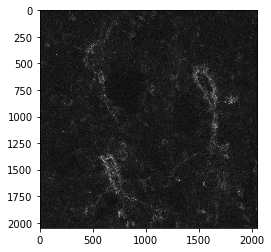

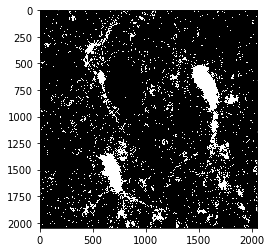

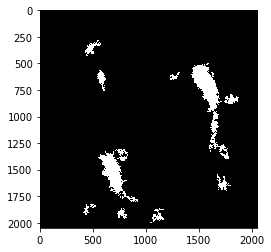

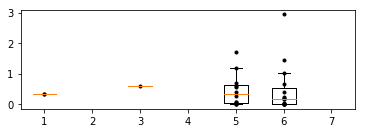

In [8]:
alpha_binning, alpha_plot_data, alpha_x, alpha_1_y = PNNs.PNN_binning(img, feat_df, min_obj_size=3000, feat = 'alpha', box_plot=True)


In [9]:
alpha_binning

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2,Euc,Bin
0,0,0.0,4.066274e-01,1.234418,1.729094,0.934477,0.130155,0.351253,2.015855,0.503933,...,37.0,509.015730,1142.000000,19.158695,200.923109,1.491304,0.408862,NaN,125.992063,5.0
1,1,1.0,7.617790e-02,22.602545,2.844596,0.935092,0.129522,0.352340,3.622573,0.723953,...,121.0,506.762867,1151.349323,19.015180,233.703120,1.981142,1.475014,0.141288,120.917327,5.0
2,2,2.0,1.473815e-08,22.318937,2.738254,0.845722,0.204613,0.245884,1.783135,0.439190,...,651.0,992.308138,1406.011083,21.289274,259.155908,2.653319,1.542021,0.324345,167.370846,6.0
3,3,3.0,1.199997e+00,0.315534,3.486660,0.684978,0.307101,0.151410,1.476176,0.322574,...,552.0,534.741736,1124.659826,28.118277,246.298042,1.584998,3.505944,0.972378,124.823876,5.0
4,4,4.0,6.867712e-01,4.453814,2.048315,0.455501,0.440563,0.078401,1.097825,0.089108,...,95.0,524.004213,1153.821478,19.130313,215.748511,1.905066,1.853615,NaN,107.056060,5.0
5,5,5.0,3.417332e-02,0.008623,2.716543,0.412137,0.466950,0.068300,1.372950,0.271641,...,651.0,1527.849205,1289.100075,62.646489,333.839246,0.801680,0.000802,0.000095,362.295460,6.0
6,6,6.0,1.036454e+00,1.144086,1.817863,0.899142,0.163010,0.299709,1.504469,0.335314,...,44.0,1273.056117,1260.794551,15.521922,184.073643,1.497412,1.090887,NaN,321.014018,6.0
7,7,7.0,1.737973e-01,0.173863,3.209750,0.865935,0.189659,0.263946,2.116179,0.527450,...,651.0,1531.519726,1266.492676,18.100289,275.027304,2.622062,0.028056,0.003549,350.697876,6.0
8,8,8.0,1.235342e-07,23.080683,2.520168,0.780448,0.248782,0.199595,1.946014,0.486129,...,496.0,1274.293518,1264.200154,24.891050,217.978307,1.351537,1.749976,0.237328,318.025156,6.0
9,9,9.0,2.125024e-01,7.290224,1.958600,0.057650,0.782795,0.007449,1.015960,0.015709,...,51.0,1280.257552,1263.243048,28.388398,226.960936,1.236547,1.385392,NaN,319.156701,6.0


In [10]:
feat_df = pd.read_csv(feat_name)
feat_df

,Unnamed: 0,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,...,straightness,MSD_ratio,frames,X,Y,Quality,Mean_Intensity,SN_Ratio,Deff1,Deff2
0,0,0.0,4.066274e-01,1.234418,1.729094,0.934477,0.130155,0.351253,2.015855,0.503933,...,0.181068,0.197753,37.0,509.015730,1142.000000,19.158695,200.923109,1.491304,0.408862,NaN
1,1,1.0,7.617790e-02,22.602545,2.844596,0.935092,0.129522,0.352340,3.622573,0.723953,...,0.003115,10.324101,121.0,506.762867,1151.349323,19.015180,233.703120,1.981142,1.475014,0.141288
2,2,2.0,1.473815e-08,22.318937,2.738254,0.845722,0.204613,0.245884,1.783135,0.439190,...,0.005438,0.324045,651.0,992.308138,1406.011083,21.289274,259.155908,2.653319,1.542021,0.324345
3,3,3.0,1.199997e+00,0.315534,3.486660,0.684978,0.307101,0.151410,1.476176,0.322574,...,0.029159,0.009585,552.0,534.741736,1124.659826,28.118277,246.298042,1.584998,3.505944,0.972378
4,4,4.0,6.867712e-01,4.453814,2.048315,0.455501,0.440563,0.078401,1.097825,0.089108,...,0.107175,0.014230,95.0,524.004213,1153.821478,19.130313,215.748511,1.905066,1.853615,NaN
5,5,5.0,3.417332e-02,0.008623,2.716543,0.412137,0.466950,0.068300,1.372950,0.271641,...,0.000699,1.017559,651.0,1527.849205,1289.100075,62.646489,333.839246,0.801680,0.000802,0.000095
6,6,6.0,1.036454e+00,1.144086,1.817863,0.899142,0.163010,0.299709,1.504469,0.335314,...,0.126723,0.033046,44.0,1273.056117,1260.794551,15.521922,184.073643,1.497412,1.090887,NaN
7,7,7.0,1.737973e-01,0.173863,3.209750,0.865935,0.189659,0.263946,2.116179,0.527450,...,0.001234,0.887160,651.0,1531.519726,1266.492676,18.100289,275.027304,2.622062,0.028056,0.003549
8,8,8.0,1.235342e-07,23.080683,2.520168,0.780448,0.248782,0.199595,1.946014,0.486129,...,0.004089,0.841225,496.0,1274.293518,1264.200154,24.891050,217.978307,1.351537,1.749976,0.237328
9,9,9.0,2.125024e-01,7.290224,1.958600,0.057650,0.782795,0.007449,1.015960,0.015709,...,0.074728,0.163186,51.0,1280.257552,1263.243048,28.388398,226.960936,1.236547,1.385392,NaN


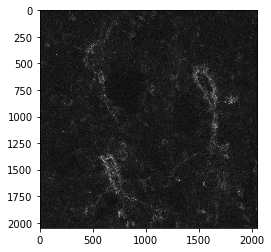

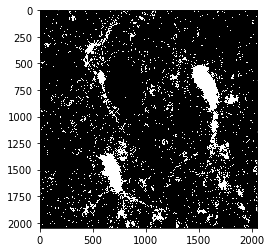

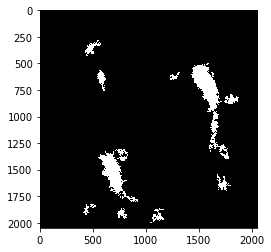

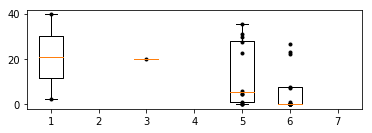

In [11]:
D_fit_binning, D_fit_plot_data, D_fit_x, D_fit_1_y = PNNs.PNN_binning(img, feat_df, min_obj_size=3000, feat = 'D_fit', box_plot=True)


In [12]:
feat_df = pd.read_csv(feat_name)

In [ ]:
D_fit_binning, D_fit_plot_data, D_fit_x, D_fit_1_y = PNNs.PNN_binning(img, feat_df, min_obj_size=3000, feat = 'D_fit', box_plot=True)
